# Tutorial 1b: analysing simulation outputs
TODO:
* dlmontepython read in data
* plt plotting of outputs
* ase plotting of configurations?
* dlmontepython modificaiton of inputs for different params
* formatting check

Examining the output files
--------------------------

A successful DL_MONTE calculation will produce a number of output files::

* OUTPUT.000 - details of the simulation, statistics, running time, or errors if the calculation failed.
* REVCON.000 - the final configuration in the format specified
* PTFILE.000 - statistics though will eventually be deprecated in favour of
* YAMLDAT.000 - statistics in the yaml format
* ARCHIVE.000/HISTORY.000/TRAJECTORY.000 - the trajectory in the specified format

For analysis we will typically process the YAMLDAT.000 and visualise the trajectory files.  
However for understanding how the simulation proceeds it is useful to have some familiarity with the OUTPUT file.

### The OUTPUT file
The file begins with a header detailing the version, authors and suggested citations, followed by the brief summary of details of the simulation as specified in the input files. A section headed *simulation parameters* then specifies all parameter values that will be used within the simulation.

The final step before starting the calculation is to determine the initial energy of the system and the details of this are printed in a block::

```
 --------------------------------------------------
                  initial energies 
 --------------------------------------------------

 break down of energies for box:   1

 total energy                       -0.7037212307E+03
 reciprocal space coulomb            0.0000000000E+00
 real space coulomb                  0.0000000000E+00
 external mfa coulomb                0.0000000000E+00
 nonbonded two body (vdw)           -0.7037212307E+03
 bonded two body (pair)              0.0000000000E+00
 nonbonded three body                0.0000000000E+00
 bonded three body (angle)           0.0000000000E+00
 bonded four body (angle)            0.0000000000E+00
 many body energy                    0.0000000000E+00
 external potential energy           0.0000000000E+00
 total virial                        0.0000000000E+00
 volume                              0.1620247087E+04
``` 

This is followed by a partial breakdown per molecule type in the system and the time taken to initialise the calculation.  


There after every *print* steps as specified in the CONTROL file a block is printed to the OUTPUT.000 file::

```
 Iteration        10000 - elapsed time:  0 h :  0 m :  0.301 s

 ====================================================================================================
      step      en-total            h-total             coul-rcp            coul-real
      step      en-vdw              en-three            en-pair             en-angle 
      step      en-four             en-many             en-external         en-extMFA
      step      volume              cell-a              cell-b              cell-c   
      step      alpha               beta                gamma 
      r-av      en-total            h-total             coul-rcp            coul-real
      r-av      en-vdw              en-three            en-pair             en-angle 
      r-av      en-four             en-many             en-external         en-extMFA
      r-av      volume              cell-a              cell-b              cell-c   
      r-av      alpha               beta                gamma 
 ----------------------------------------------------------------------------------------------------
     10000    -0.1006733261E+04   -0.3030120301E+03    0.0000000000E+00    0.0000000000E+00
              -0.1006733261E+04    0.0000000000E+00    0.0000000000E+00    0.0000000000E+00
               0.0000000000E+00    0.0000000000E+00    0.0000000000E+00    0.0000000000E+00
               0.1620247087E+04    0.1174520000E+02    0.1174520000E+02    0.1174520000E+02
               0.9000000000E+02    0.9000000000E+02    0.9000000000E+02


              -0.1014992775E+04   -0.3112715438E+03    0.0000000000E+00    0.0000000000E+00
              -0.1014992775E+04    0.0000000000E+00    0.0000000000E+00    0.0000000000E+00
               0.0000000000E+00    0.0000000000E+00    0.0000000000E+00    0.0000000000E+00
               0.1620247087E+04    0.1174520000E+02    0.1174520000E+02    0.1174520000E+02
               0.9000000000E+02    0.9000000000E+02    0.9000000000E+02
           
 LJ       c        512.0000        512.0000

 lj                1.0000          1.0000
 ----------------------------------------------------------------------------------------------------
  equilibration period ended at step        10000
 ----------------------------------------------------------------------------------------------------
 ```

This specifies the same breakdown in a tabulated form, including the iteration number and time taken.  By using the command:

```
 $ grep time OUTPUT.000
```
you can quickly gauge the progress of your calculation.

DL_MONTE runs a *check* of the system at regular intervals to verify that the system is behaving correctly.
This typically involves calculating the energy from scratch and comaring it with the running total, the result is printed to the OUTPUT.000 with a line looking like::

```
 $ grep U_recalc OUTPUT.000

 Workgroup    0, box    1 check: U_recalc - U_accum =  0.35129E-10  0.29580E-10  0.57773E-13 -0.34894E-13 (internal, kT, kT/atom, dU/U)
``` 

The final value is the relative energy difference which should be of the order of the working precision, typically ending E-13 or E-14.

Finally at the end of the simulation a summary block detailing the average values during the simulation (excluding the first *equilbration* steps) and their fluctations, the final energies, and 'processing data' detailing time, move data and final parameters:

```
----------------------------------------------------------------------------
                          processing data 
 ----------------------------------------------------------------------------

 total no of attempted & empty atom moves :    110000         0
 successful no of atom moves & acceptance :     42987      0.39079091

 displacement (Angstroms) for LJ       c :   0.4160


 pure simulation time (excl. init.):  0 h :  0 m :  3.492 s


 total elapsed time   (incl. init.):  0 h :  0 m :  3.498 s


 normal exit 
```  

Upon a successful completion of a simulation run, the OUTPUT.000 file will end with the string **normal exit**. 
To quickly check for this try::

```
 $ grep "normal exit" OUTPUT.000
```

### Analysing the YAMLDATA

To see if the simulation converged to equilibrium, we need to output sufficient information during the simulation to interpret it fully. This often leads to issues with hard drive space, as full summaries fo the simulaiton details can take up quite a lot of space. One way of balancing this trade-off is to extract only summary data from the simulations, such as simulation total energy. To do this, take the CONTROL files from the previous exercise and add the following line: 

```
yamldata 1000
```

Now, if we rerun the simulation, a `YAMLDATA.000` file is geneerated, containing vital statistics about the simulation progression, which we can analyse using the `dlmontepython` and `pandas` python libraries:

In [5]:
import matplotlib.pyplot as plt
from dlmontepython.htk.sources import dlptfile
import pandas as pd
import os

#This line reads in the file to a dataframe
yaml_out = dlptfile.load_yaml('./Tutorial_2_files//')
yaml_df = pd.DataFrame(yaml_out.data)
yaml_df.head()

timestamp      energy    enthalpy   energyvdw       volume
0       1000 -765.915618 -588.800119 -765.915618  1620.452878
1       2000 -800.867802 -623.778978 -800.867802  1620.208825
2       3000 -852.417373 -675.268398 -852.417373  1620.759153
3       4000 -892.871414 -715.748482 -892.871414  1620.520876
4       5000 -950.054125 -773.048071 -950.054125  1619.451551

We can now visualise it with a plot:

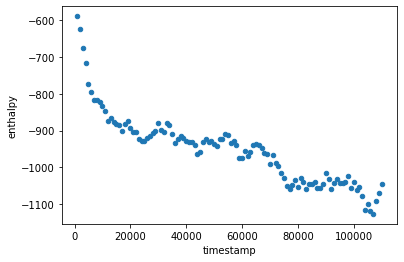

In [9]:
yaml_df.plot.scatter(x='timestamp', y='enthalpy')

plt.show()

So how can we tell if the simulation has run to completion? 
We want the energy to converge to a fixed value, but the final energy fluctuates significantly. 
From manual inspection, we aren't able to confirm that there isn't a slow drift in the energy value. 
Instead, we can use a variety of mathematical algorithms to analyse the flucturations in energy over time, finding:

* How many timesteps it takes to reach an equilibrated value.
* How many timesteps it takes for eqilibrated data to become *uncorrelated* from the previous values of energy. 

There are a few algorithms which can analyse this, but most are based on autocorrelation - subtracting the energy data at time $t$ from a shifted energy value at time $t+k$. 
As $k$ increases, the signals will become more and more different, reducing the autocorrelated value.


A value of 1 would indicate that the sequences are indentical, while a value of 0 indicates they're completely different. 
We want the autocorrelated value to decay to 0 very quickly as a function of $k$.

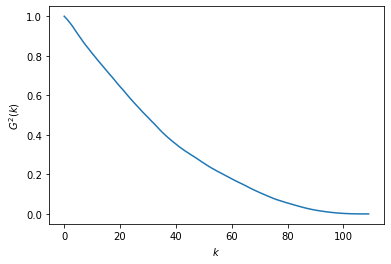

In [7]:
import numpy as np

def autocorrelate(sequence):
    result = np.correlate(sequence[:], sequence[:], mode='full')**2 #square to remove negative values
    return result[result.size // 2:]/result.max()
#
plt.plot(autocorrelate(yaml_df['energy'][::]-max(yaml_df['energy'])))
plt.ylabel('$G^2(k)$')
plt.xlabel('$k$')
plt.show()


As we can see, $G^2(k)$ decays almost linearly for most of the simulation time. 
To get quantitiative figures of merit, we can install the `pymbar` package to analyse the outputs. They use a modified autocorrelation sequence to analyse simulatino outputs for equilibration and correlation time. You can read the paper [here](https://pubs.acs.org/doi/10.1021/acs.jctc.5b00784) for an explanation of how to use the software.

### Questions to ask yourself:

* Did the system reach equilibrium?
* How many uncorrelated samples can we extract from the simulation? 
* How can we increase the number of uncorrelated samples extracted?

## Analysing system configurations

In addition to analysing the data coming out fo the simulations, we can also view the atoms inside of our simulation, to look for any weird nonphysical interactions or unusual atomic locations. 
To do this, we use the [`ase`](https://wiki.fysik.dtu.dk/ase/index.html) library, a useful set of tools for handling atoms and molecules in molecular simulation environments. I've writtens ome interfaces with dl_monte, which we'll import from the *scripts* directory.

In [1]:
from scripts import ase_hack
from ase.visualize import view
from ase import Atoms

atoms_to_visualise = Atoms()
with open('./ARCHIVE.000') as f:
    atoms = ase_hack.read_dlm(f)
    first = next(atoms)
    
for molecule in first.values():
    atoms_to_visualise.set_cell(molecule[1].cell)
    atoms_to_visualise += molecule[1]

view(atoms_to_visualise, viewer='x3d')

### Questions to ask yourself:

* Do the atoms seem well-distributed or very clumped together?
* How can you compare different configurations in the trajectory?


Extra exercises to do
-----------------------------

Using tutorial 1, modify the simulation parameters in the `CONTROL` and `FIELD` files like the random seed and interaction strengths/distances. 
Write down what you expect to happen in the simulaiton, then run it and compare against the original simulation. 
What changed? What stayed the same?
How was the equilibration time and statistical efficiency of the simulation affected by your changes?